# 0. Install Dependencies and Bring in Data

In [2]:
pip install tensorflow pandas matplotlib scikit-learn



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip uninstall tensorflow-gpu


Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

2024-11-23 22:30:41.877891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 22:30:41.958977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 22:30:41.991578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732381242.042932  281737 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732381242.054764  281737 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 22:30:42.135002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [7]:
!pip list

Package                 Version
----------------------- -----------
absl-py                 2.1.0
aiofiles                23.2.1
annotated-types         0.7.0
anyio                   4.6.2.post1
asttokens               2.4.1
astunparse              1.6.3
certifi                 2024.8.30
charset-normalizer      3.4.0
click                   8.1.7
comm                    0.2.2
contourpy               1.3.0
cycler                  0.12.1
debugpy                 1.8.7
decorator               5.1.1
executing               2.1.0
fastapi                 0.115.5
ffmpy                   0.4.0
filelock                3.16.1
flatbuffers             24.3.25
fonttools               4.54.1
fsspec                  2024.10.0
gast                    0.6.0
google-pasta            0.2.0
gradio                  5.6.0
gradio_client           1.4.3
grpcio                  1.67.0
h11                     0.14.0
h5py                    3.12.1
httpcore                1.0.7
httpx                   0.27.2
huggin

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

W0000 00:00:1732381258.525604  281737 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
vectorizer.adapt(X.values)

2024-11-23 22:31:03.219268: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253720368 exceeds 10% of free system memory.


In [13]:
vectorized_text = vectorizer(X.values)

2024-11-23 22:31:07.195918: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253720368 exceeds 10% of free system memory.
2024-11-23 22:31:08.204376: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [14]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

NameError: name 'model' is not defined

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 4637s 663ms/step - loss: 0.0827 - val_loss: 0.0484


In [27]:
history

In [61]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

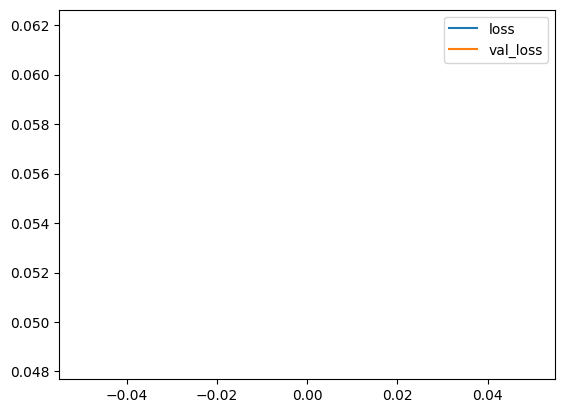

In [62]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [29]:
print(history.history)


{'loss': [0.061946164816617966], 'val_loss': [0.0483638197183609]}


# 3. Make Predictions

In [1]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

NameError: name 'vectorizer' is not defined

In [31]:
import numpy as np
print(np.array(input_text).shape)


(1800,)


In [30]:
print(model.input_shape)


(None, 1800)


In [32]:
import numpy as np

# Add a batch dimension to input_text
input_text = np.expand_dims(input_text, axis=0)

# Check the new shape
print(input_text.shape)  # Output should be (1, 1800)

# Now use the predict function
res = model.predict(input_text)


(1, 1800)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


In [33]:
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [34]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 0, 0]])

In [35]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [36]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [37]:
res.shape

(1, 6)

# 4. Evaluate Model

In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2024-11-23 20:18:07.474233: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9028998017311096, Recall:0.5625513195991516, Accuracy:0.47241726517677307


# 5. Test and Gradio

In [42]:
!pip install gradio jinja2

  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached anyio-4.6.2.post1-py3-none-any.whl.metadata (4.7 kB)
  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached python_multipart-0.0.12-py3-none-any.whl.metadata (1.9 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached websockets-12.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [29]:
import tensorflow as tf
import gradio as gr

/home/vishwadharani/Code+Notes/CommentToxicity/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
model.save('toxicity.keras')


In [20]:
model = tf.keras.models.load_model('toxicity.keras')


/home/vishwadharani/Code+Notes/CommentToxicity/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 32 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
input_str = vectorizer('hey i freaking hate you!')
input_vector = np.expand_dims(input_str, axis=0)  # Add batch dimension
res = model.predict(input_vector)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


In [23]:
def score_comment(comment):
    # Preprocess input
    input_vector = vectorizer(comment)
    input_vector = np.expand_dims(input_vector, axis=0)
    
    # Predict
    prediction = model.predict(input_vector)
    
    # Return a response
    return f"Score: {prediction[0][0]}"


In [24]:
input_str = vectorizer('hey i freaken hate you!')


In [66]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


In [25]:
res

array([[0.7650754 , 0.01522413, 0.3341354 , 0.0215348 , 0.35896286,
        0.04324976]], dtype=float32)

In [26]:
pip install --upgrade gradio



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
def score_comment(comment):
    # Preprocess the input
    input_vector = vectorizer(comment)
    input_vector = np.expand_dims(input_vector, axis=0)

    print(f"Input vector: {input_vector}")  # Debugging

    # Predict
    prediction = model.predict(input_vector)
    print(f"Prediction: {prediction}")  # Debugging

    # Return a response
    return f"Toxicity Score: {prediction[0][0]}"


In [30]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Enter a comment'),
    outputs=gr.Textbox()
)

# Launch the interface
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://72993672d1a15ccb58.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Input vector: [[171   0   0 ...   0   0   0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction: [[6.4887553e-03 3.9063216e-06 1.8261141e-03 9.7131800e-05 2.7581442e-03
  4.8660036e-04]]
Input vector: [[  8 457 319 ...   0   0   0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Prediction: [[0.0863883  0.00034009 0.01823247 0.00255022 0.03890613 0.00782357]]
Input vector: [[   8 7158  363 ...    0    0    0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction: [[0.7705586  0.01730345 0.34765866 0.02364161 0.36663023 0.04679767]]
